In [1]:
# Parameters
herb_path = "Processed_herb_adata.h5ad"
zhou_path = "Processed_zhou_adata.h5ad"



Author: Erno Hänninen

Created: 2023-06-02

Title: Concat_Zhou_Herb.ipynb

Description:
 - Filters and annotates cell types to the raw timepoint data from Herb paper
 
Procedure:
 - ...

List of non-standard modules:
 - scanpy


### Read data and delete unnecessary columns

In [2]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#Read the integrated reference data (Fig1 from the paper)
herb_adata = sc.read(herb_path)
zhou_adata = sc.read(zhou_path)

In [4]:
zhou_adata.uns["log1p"] = {"base":None}
zhou_adata

AnnData object with n_obs × n_vars = 122429 × 24996
    obs: 'Cell_types', 'sample'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p'

In [5]:
del(herb_adata.obs["orig.ident"], herb_adata.obs["nCount_RNA"], herb_adata.obs["nFeature_RNA"], herb_adata.obs["percent.mt"])
herb_adata.var=herb_adata.var.set_index("features")
herb_adata.uns["log1p"] = {"base":None}
herb_adata

AnnData object with n_obs × n_vars = 40927 × 33694
    obs: 'sample', 'Cell_types'
    uns: 'log1p'

### Harmonize the cell names

In [6]:
zhou_adata.obs["Cell_types"].value_counts()

Neuron       43965
NP           16898
Astrocyte    12829
NE           11515
Microglia    11067
OPC          10955
Ependy        5389
OL            3789
VLMC          2083
Mural         2011
Endoth        1928
Name: Cell_types, dtype: int64

In [7]:
zhou_adata.obs['Cell_types_2'] = (
    zhou_adata.obs["Cell_types"]
    .map(lambda x: {"OL": "Oligo"}.get(x, x))
    .astype("category")
)

In [8]:
herb_adata.obs["Cell_types"].value_counts()

Neurons                          11949
RadialGlia                        4031
Fibroblasts                       3183
Astrocyte Progenitors             2962
Dividing                          2508
Oligodendrocytes [Immature]       2331
Oligodendrocyte Progenitors_1     2062
Ependymal                         1663
Oligodendrocyte Progenitors_2     1473
Astrocytes                        1341
Neural Progenitors_1              1208
Tanycytes                         1133
Microglia                         1111
Neural Progenitors_2               752
Blood                              570
Oligodendrocytes [Maturing]        567
Pericytes_1                        464
Oligodendrocytes [Dividing]        388
Endothelial [Arterial_1]           277
Oligodendrocytes [Mature]          277
Endothelial [Venous]               257
Pericytes_2                        206
Endothelial [Arterial_2]           114
vSMC                               100
Name: Cell_types, dtype: int64

In [9]:
herb_adata.obs['Cell_types_2'] = (
    herb_adata.obs["Cell_types"]
    .map(lambda x: {"Oligodendrocyte Progenitors_1": "OPC", "Oligodendrocyte Progenitors_2": "OPC","Oligodendrocytes [Immature]": "Oligo", "Oligodendrocytes [Maturing]":"Oligo", "Oligodendrocytes [Dividing]":"Oligo", "Oligodendrocytes [Mature]":"Oligo", "vSMC":"Mural", "Ependymal":"Ependy",
                    "Neural Progenitors_1":"NP", "Neural Progenitors_2":"NP", "Neurons":"Neuron", "Astrocyte Progenitors":"Astrocyte", "Astrocytes":"Astrocyte", "Endothelial [Venous]":"Endoth", "Endothelial [Arterial_2]": "Endoth", "Endothelial [Arterial_1]":"Endoth", "Pericytes_1":"VLMC", "Pericytes_2":"Pericyte"}.get(x, x))
    .astype("category")
)

In [10]:
#Resulting clusters
zhou_adata.obs["Cell_types_2"].value_counts()

Neuron       43965
NP           16898
Astrocyte    12829
NE           11515
Microglia    11067
OPC          10955
Ependy        5389
Oligo         3789
VLMC          2083
Mural         2011
Endoth        1928
Name: Cell_types_2, dtype: int64

In [11]:
herb_adata.obs["Cell_types_2"].value_counts()

Neuron         11949
Astrocyte       4303
RadialGlia      4031
Oligo           3563
OPC             3535
Fibroblasts     3183
Dividing        2508
NP              1960
Ependy          1663
Tanycytes       1133
Microglia       1111
Endoth           648
Blood            570
VLMC             464
Pericyte         206
Mural            100
Name: Cell_types_2, dtype: int64

### Merge zhou and herb

In [12]:
merged_adata = zhou_adata.concatenate(herb_adata, batch_key=None, join="outer")
merged_adata

/home/bns631/.conda/envs/PYenv/lib/python3.10/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/home/bns631/.conda/envs/PYenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 163356 × 35251
    obs: 'Cell_types', 'sample', 'Cell_types_2'
    var: 'gene_ids-0', 'feature_types-0'

In [13]:
merged_adata.var_names_make_unique()
merged_adata.layers["counts"] = merged_adata.X.copy()


### Process the data

In [14]:
merged_adata.var['mt'] = merged_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(merged_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

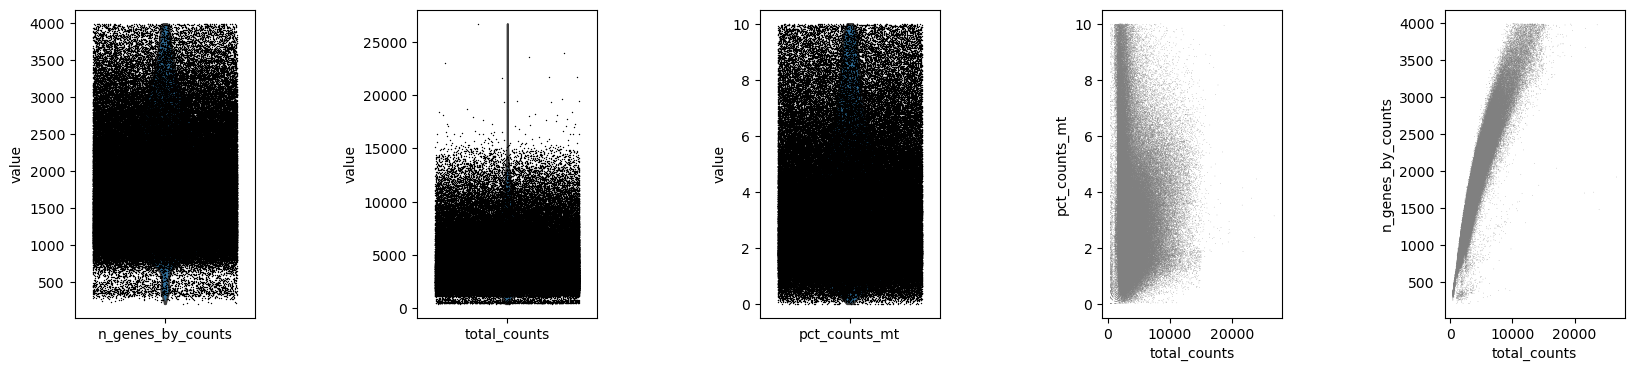

In [15]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5,  figsize=(20,4), gridspec_kw={'wspace':0.9})
ax1_dict = sc.pl.violin(merged_adata, ['n_genes_by_counts'], jitter=0.4, show=False, ax = ax1) 
ax2_dict = sc.pl.violin(merged_adata, ['total_counts'], jitter=0.4, show=False, ax = ax2)
ax3_dict = sc.pl.violin(merged_adata, ['pct_counts_mt'], jitter=0.4, show=False, ax = ax3)    
ax4_dict = sc.pl.scatter(merged_adata, x='total_counts', y='pct_counts_mt', show=False, ax=ax4)
ax5_dict = sc.pl.scatter(merged_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [16]:
sc.pp.filter_cells(merged_adata, min_genes=500)

In [17]:
merged_adata

AnnData object with n_obs × n_vars = 162115 × 35251
    obs: 'Cell_types', 'sample', 'Cell_types_2', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids-0', 'feature_types-0', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts'

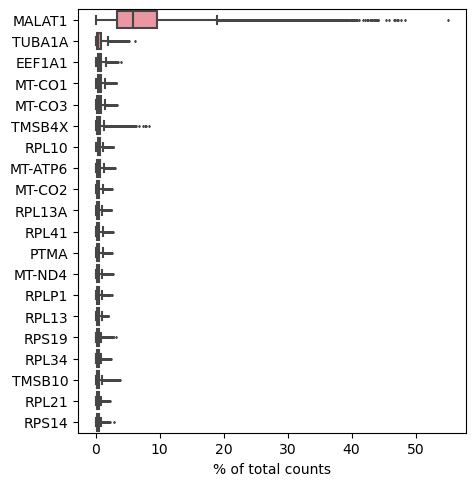

In [18]:
sc.pl.highest_expr_genes(merged_adata, n_top=20)

In [19]:
import numpy as np
ribo = merged_adata.var_names.str.startswith(('RPL', "RPS"))
mito = merged_adata.var_names.str.startswith('MT-')
remove = np.add(mito, ribo)
keep = np.invert(remove)

merged_adata = merged_adata[:,keep]

In [20]:
merged_adata

View of AnnData object with n_obs × n_vars = 162115 × 35132
    obs: 'Cell_types', 'sample', 'Cell_types_2', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids-0', 'feature_types-0', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts'

/home/bns631/.conda/envs/PYenv/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/home/bns631/.conda/envs/PYenv/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


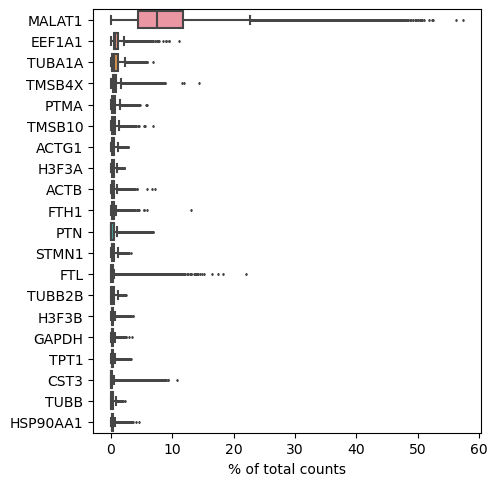

In [21]:
sc.pl.highest_expr_genes(merged_adata, n_top=20)

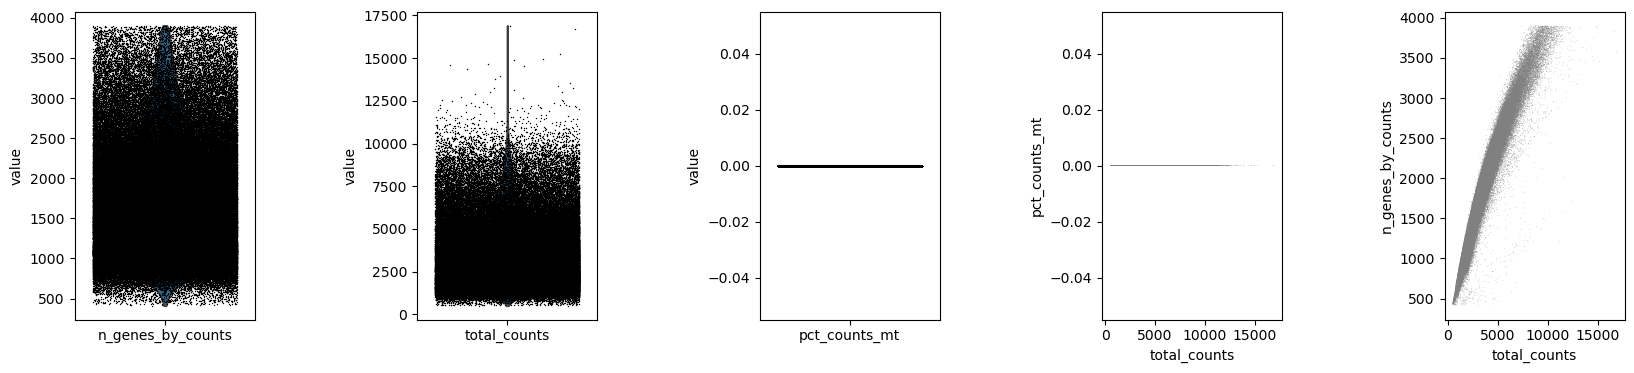

In [22]:
# Recompute qc metrics
sc.pp.calculate_qc_metrics(merged_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5,  figsize=(20,4), gridspec_kw={'wspace':0.9})
ax1_dict = sc.pl.violin(merged_adata, ['n_genes_by_counts'], jitter=0.4, show=False, ax = ax1) 
ax2_dict = sc.pl.violin(merged_adata, ['total_counts'], jitter=0.4, show=False, ax = ax2)
ax3_dict = sc.pl.violin(merged_adata, ['pct_counts_mt'], jitter=0.4, show=False, ax = ax3)    
ax4_dict = sc.pl.scatter(merged_adata, x='total_counts', y='pct_counts_mt', show=False, ax=ax4)
ax5_dict = sc.pl.scatter(merged_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [23]:
sc.pp.normalize_total(merged_adata, target_sum=1e4)
sc.pp.log1p(merged_adata)

In [24]:
merged_adata.X

<162115x35132 sparse matrix of type '<class 'numpy.float32'>'
	with 283354353 stored elements in Compressed Sparse Row format>

In [25]:
doublet_adata = merged_adata.copy()
print(merged_adata.shape)
doublet_adata.X = doublet_adata.layers["counts"].copy()

(162115, 35132)


In [26]:
print(doublet_adata.X)

  (0, 840)	1.0
  (0, 19721)	1.0
  (0, 34209)	2.0
  (0, 15939)	1.0
  (0, 15940)	1.0
  (0, 31332)	1.0
  (0, 33391)	2.0
  (0, 18751)	1.0
  (0, 33323)	3.0
  (0, 17141)	1.0
  (0, 18647)	1.0
  (0, 34059)	1.0
  (0, 11956)	4.0
  (0, 19946)	1.0
  (0, 33142)	4.0
  (0, 16415)	2.0
  (0, 4992)	2.0
  (0, 20490)	1.0
  (0, 16577)	2.0
  (0, 3560)	4.0
  (0, 13160)	1.0
  (0, 30746)	4.0
  (0, 10754)	1.0
  (0, 18508)	2.0
  (0, 30738)	3.0
  :	:
  (162114, 29288)	1.0
  (162114, 15981)	1.0
  (162114, 29851)	3.0
  (162114, 31395)	1.0
  (162114, 4004)	1.0
  (162114, 15846)	2.0
  (162114, 18773)	1.0
  (162114, 8822)	1.0
  (162114, 3267)	1.0
  (162114, 31234)	1.0
  (162114, 29735)	1.0
  (162114, 32300)	3.0
  (162114, 29337)	1.0
  (162114, 12272)	2.0
  (162114, 12005)	1.0
  (162114, 5405)	1.0
  (162114, 9273)	1.0
  (162114, 12080)	1.0
  (162114, 33445)	1.0
  (162114, 13601)	2.0
  (162114, 15636)	1.0
  (162114, 9377)	1.0
  (162114, 20555)	1.0
  (162114, 18465)	2.0
  (162114, 11761)	1.0


In [27]:
import scrublet as scr

# split per batch into new objects.
batches = doublet_adata.obs['sample'].cat.categories.tolist()
alldata = {}
for batch in batches:
    tmp = doublet_adata[doublet_adata.obs['sample'] == batch,]
    print(batch, ":", tmp.shape[0], " cells")
    scrub = scr.Scrublet(tmp.X)
    out = scrub.scrub_doublets(verbose=False, n_prin_comps = 20)
    alldata[batch] = pd.DataFrame({'doublet_score':out[0],'predicted_doublets':out[1]},index = tmp.obs.index)
    print(alldata[batch].predicted_doublets.sum(), " predicted_doublets")

CS13 : 3962  cells


8  predicted_doublets
CS14 : 604  cells


/home/bns631/.conda/envs/PYenv/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])


1  predicted_doublets
CS15 : 2920  cells


3  predicted_doublets
CS22_2_hypo : 1733  cells


2  predicted_doublets
CS22_hypo : 1953  cells


2  predicted_doublets
GW7-lane1 : 11221  cells


208  predicted_doublets
GW7-lane2 : 11223  cells


237  predicted_doublets
GW8-1 : 5877  cells


2  predicted_doublets
GW8-2 : 4858  cells


0  predicted_doublets
GW10 : 7090  cells


4  predicted_doublets
GW12_01 : 6872  cells


157  predicted_doublets
GW12_02 : 8756  cells


1  predicted_doublets
GW15-A : 3607  cells


6  predicted_doublets
GW15-M : 4286  cells


3  predicted_doublets
GW15-P : 6270  cells


5  predicted_doublets
GW16_hypo : 9319  cells


21  predicted_doublets
GW18-01-A : 6516  cells


190  predicted_doublets
GW18-01-M : 6567  cells


244  predicted_doublets
GW18-01-P : 3733  cells


114  predicted_doublets
GW18-02-lane1 : 4356  cells


153  predicted_doublets
GW18-02-lane2 : 10911  cells


680  predicted_doublets
GW18-02-lane3 : 5143  cells


196  predicted_doublets
GW18_hypo : 5084  cells


73  predicted_doublets
GW19_hypo : 2971  cells


5  predicted_doublets
GW20-A : 4185  cells


68  predicted_doublets
GW20-M : 4225  cells


80  predicted_doublets
GW20-P : 5850  cells


171  predicted_doublets
GW20_34_hypo : 2275  cells


26  predicted_doublets
GW22T_hypo1 : 2797  cells


6  predicted_doublets
GW25_3V_hypo : 6951  cells


40  predicted_doublets


In [28]:
# add predictions to the merged_adata object.
scrub_pred = pd.concat(alldata.values())
merged_adata.obs['doublet_scores'] = scrub_pred['doublet_score'] 
merged_adata.obs['predicted_doublets'] = scrub_pred['predicted_doublets'] 
merged_adata.obs["predicted_doublets"].value_counts()

False    159409
True       2706
Name: predicted_doublets, dtype: int64

In [29]:
#merged_adata.obs['doublet_info'] = merged_adata.obs["predicted_doublets"]
merged_adata = merged_adata[merged_adata.obs['predicted_doublets'] != True,:]
del merged_adata.obs["predicted_doublets"] 
print(merged_adata.shape)

(159409, 35132)


In [30]:
merged_adata.X

<159409x35132 sparse matrix of type '<class 'numpy.float32'>'
	with 276548133 stored elements in Compressed Sparse Row format>

In [31]:
merged_adata

View of AnnData object with n_obs × n_vars = 159409 × 35132
    obs: 'Cell_types', 'sample', 'Cell_types_2', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_scores'
    var: 'gene_ids-0', 'feature_types-0', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'
    layers: 'counts'

In [32]:
merged_adata.raw = merged_adata.copy()
merged_adata.write("merged_zhou_herb.h5ad") #Write the data to file

### Plot the new cell types

#### Merged

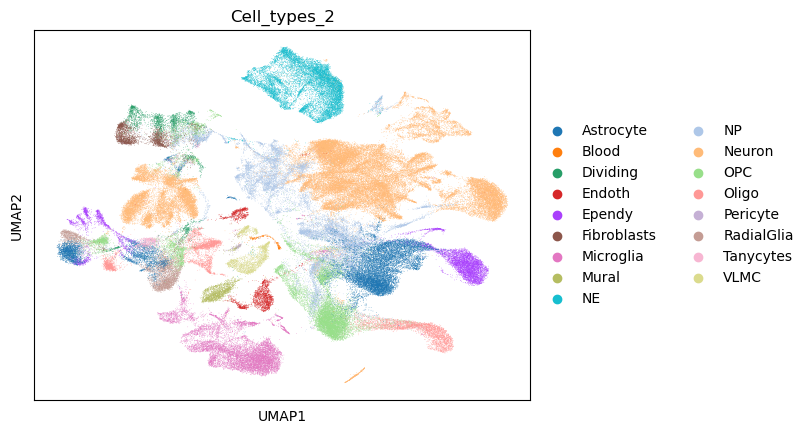

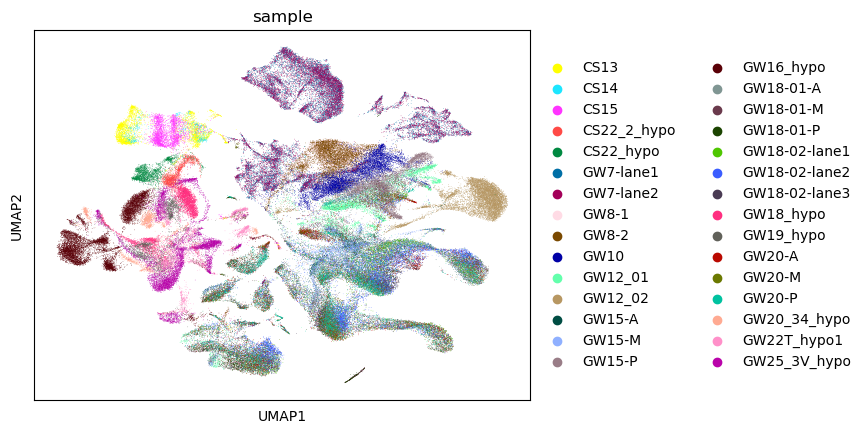

In [33]:
#Identify hvg
sc.pp.highly_variable_genes(merged_adata, n_top_genes=3000, inplace = True)

#Scale data
sc.pp.scale(merged_adata)

#Process the data
sc.tl.pca(merged_adata)
sc.pp.neighbors(merged_adata)
sc.tl.umap(merged_adata)

sc.pl.umap(merged_adata, color="Cell_types_2")
sc.pl.umap(merged_adata, color="sample")


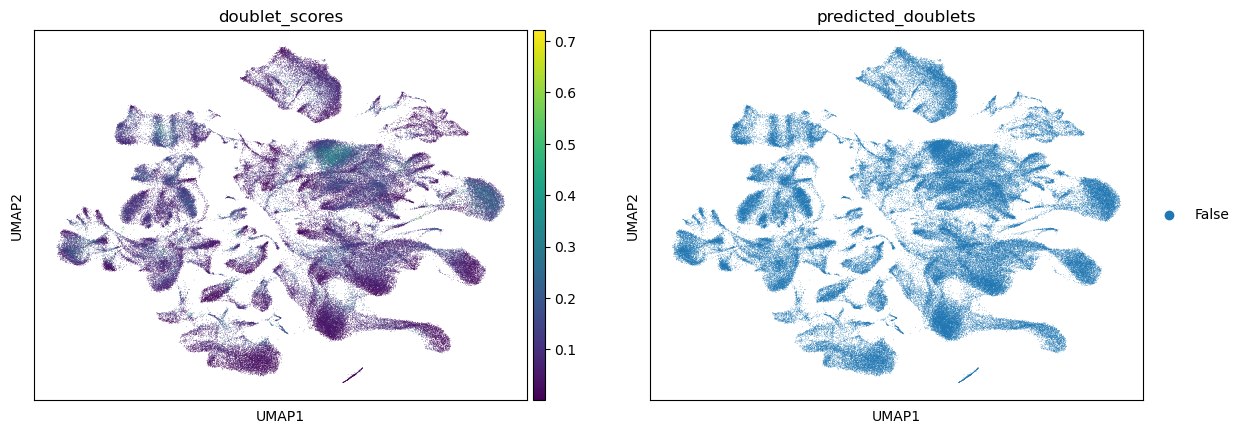

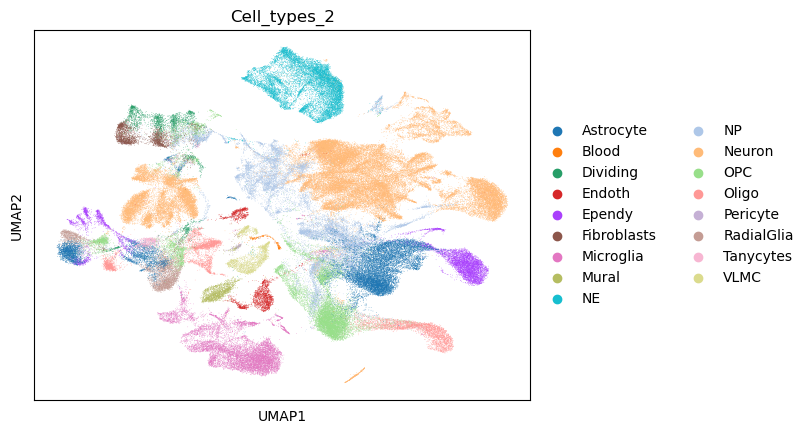

In [34]:
merged_adata.obs['doublet_scores'] = scrub_pred['doublet_score'] 
merged_adata.obs['predicted_doublets'] = scrub_pred['predicted_doublets'] 
merged_adata.obs["predicted_doublets"] = merged_adata.obs["predicted_doublets"].fillna(True)
merged_adata.obs['predicted_doublets'] = merged_adata.obs['predicted_doublets'].astype(str).astype('category')
sc.pl.umap(merged_adata, color=['doublet_scores','predicted_doublets'])
sc.pl.umap(merged_adata, color=['Cell_types_2'])